# Introduction

This is a training script for the Sprite generation task. It uses a diffusion technique called DDPM.

To get started you need following files:

*   data files:
 - sprites_1788_16x16.npy (These are all images converted to numpy arrays)
 - sprite_labels_nc_1788_16x16.npy (These are labels corresponding to the images)



# Setup

In [1]:
#install wandb for MLOps
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=afe7dc05a24350c846b8cbc2b758b0a324a90709d2b5b4438b6c047351e3bad6
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
#utility imports
from typing import Dict, Tuple
from types import SimpleNamespace
from tqdm import tqdm
from pathlib import Path
import numpy as np
from IPython.display import HTML
import wandb

#PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset

#plotting imports
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [3]:
#login to WandB: You'll need an API key
wandb.login(anonymous="allow")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Model Architecture

In [4]:
class ResidualConvBlock(nn.Module):
    """
    This class creates a residual convolution block
    """
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels

In [5]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Get output
        x = self.model(x)
        return x

In [6]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

In [7]:
class EmbedFC(nn.Module):
    """
    This class defines a generic one layer feed-forward neural network for embedding input data of
    dimensionality input_dim to an embedding space of dimensionality emb_dim.
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [8]:
#Blueprint of Unet
class ContextUnet(nn.Module):
    """
    A Unet that is conditioned on context
    """
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        """
        Constructor
        """

        #call parent class constructor
        super(ContextUnet, self).__init__()

        # setup input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #height and width of image. Divisible by 4

        # Initialize the convolution layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Two level down sampling
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

        #vectorize
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # 3 level upsampling
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Final convolutional layer
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)

        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        #upsample
        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [9]:
# Setup for saving the data and weights
DATA_DIR = Path('./data/')
SAVE_DIR = Path('./data/weights/')
SAVE_DIR.mkdir(exist_ok=True, parents=True)
save_dir = SAVE_DIR
data_dir = DATA_DIR

config = SimpleNamespace(
    # hyperparameters for WandB
    num_samples = 30,

    # diffusion hyperparameters
    timesteps = 500,
    beta1 = 1e-4,
    beta2 = 0.02,

    # network hyperparameters
    n_feat = 64, # 64 hidden dimension feature
    n_cfeat = 5, # context vector is of size 5
    height = 16, # 16x16 image

    # training hyperparameters
    batch_size = 100,
    n_epoch = 128,
    lrate = 1e-3,
)

# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
print(device)


cuda:0


# DDPM Algorithm

In [10]:
def setup_ddpm(beta1, beta2, timesteps, device):

    # construct DDPM noise schedule and sampling functions
    b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
    a_t = 1 - b_t
    ab_t = torch.cumsum(a_t.log(), dim=0).exp()
    ab_t[0] = 1

    # helper function: perturbs an image to a specified noise level
    def perturb_input(x, t, noise):
        return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

    # helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
    def _denoise_add_noise(x, t, pred_noise, z=None):
        if z is None:
            z = torch.randn_like(x)
        noise = b_t.sqrt()[t] * z
        mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
        return mean + noise

    # sample with context using DDPM algorithm
    @torch.no_grad()
    def sample_ddpm_context(nn_model, noises, context, save_rate=20):
        # array to keep track of generated steps for plotting
        intermediate = []
        pbar = tqdm(range(timesteps, 0, -1), leave=False)
        for i in pbar:
            pbar.set_description(f'sampling timestep {i:3d}')

            # reshape time tensor
            t = torch.tensor([i / timesteps])[:, None, None, None].to(noises.device)

            # Add some noise back in if i is not 1
            z = torch.randn_like(noises) if i > 1 else 0

            eps = nn_model(noises, t, c=context)    # predict noise
            noises = _denoise_add_noise(noises, i, eps, z)
            if i % save_rate==0 or i==timesteps or i<8:
                intermediate.append(noises.detach().cpu().numpy())

        intermediate = np.stack(intermediate)
        return noises.clip(-1, 1), intermediate

    return perturb_input, sample_ddpm_context

In [11]:
#create an instance of the model
nn_model = ContextUnet(in_channels=3, n_feat=config.n_feat, n_cfeat=config.n_cfeat, height=config.height).to(device)


# Data

In [12]:
class CustomDataset(Dataset):
    def __init__(self, sfilename, lfilename, transform, null_context=False):

        #load image arrays and labels
        self.sprites = np.load(sfilename)
        self.slabels = np.load(lfilename)
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")

        #get transformations to be done
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

])

In [13]:
# load dataset and construct optimizer
dataset = CustomDataset("./sprites_1788_16x16.npy", "./sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=config.lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [14]:
# helper function: perturbs an image to a specified noise level
perturb_input, sample_ddpm_context = setup_ddpm(config.beta1,
                                                config.beta2,
                                                config.timesteps,
                                                device)

In [15]:
noises = torch.randn(config.num_samples, 3,
                     config.height, config.height).to(device)

# A fixed context vector to sample from
ctx_vector = F.one_hot(torch.tensor([0,0,0,0,0,0,   # hero
                                     1,1,1,1,1,1,   # non-hero
                                     2,2,2,2,2,2,   # food
                                     3,3,3,3,3,3,   # spell
                                     4,4,4,4,4,4]), # side-facing
                       5).to(device).float()

# Training

In [16]:
import os

# set into train mode
nn_model.train()

#initialize wandb project
run = wandb.init(project="msml612_sprite",
                 job_type="train",
                 config=config)

# pass config to wandb
config = wandb.config

#train
for ep in range(config.n_epoch):
    print(f'epoch {ep}')

    # LR Decay (linear)
    optim.param_groups[0]['lr'] = config.lrate*(1-ep/config.n_epoch)

    #progres bar
    pbar = tqdm(dataloader, mininterval=2 )
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)

        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, config.timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        pred_noise = nn_model(x_pert, t / config.timesteps, c=c)

        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()

        optim.step()

        wandb.log({"loss": loss.item(),
                   "lr": optim.param_groups[0]['lr'],
                   "epoch": ep})

    # save model periodically
    if ep%4==0 or ep == int(config.n_epoch-1):
        nn_model.eval()
        ckpt_file = SAVE_DIR/f"context_model.pth"
        torch.save(nn_model.state_dict(), ckpt_file)

        #save to WandB
        artifact_name = f"{wandb.run.id}_context_model"
        at = wandb.Artifact(artifact_name, type="model")
        at.add_file(ckpt_file)
        wandb.log_artifact(at, aliases=[f"epoch_{ep}"])

        samples, _ = sample_ddpm_context(nn_model,
                                         noises,
                                         ctx_vector[:config.num_samples])

        #Save samples
        wandb.log({
            "train_samples": [
                wandb.Image(img) for img in samples.split(1)
            ]})
wandb.finish()

wandb: Currently logged in as: adityapatkar (teamaditya). Use `wandb login --relogin` to force relogin


epoch 0


100%|██████████| 894/894 [00:23<00:00, 37.98it/s]


epoch 1


100%|██████████| 894/894 [00:15<00:00, 56.82it/s]


epoch 2


100%|██████████| 894/894 [00:14<00:00, 61.92it/s]


epoch 3


100%|██████████| 894/894 [00:13<00:00, 66.48it/s]


epoch 4


100%|██████████| 894/894 [00:13<00:00, 66.29it/s]


epoch 5


100%|██████████| 894/894 [00:14<00:00, 60.09it/s]


epoch 6


100%|██████████| 894/894 [00:14<00:00, 61.59it/s]


epoch 7


100%|██████████| 894/894 [00:13<00:00, 66.16it/s]


epoch 8


100%|██████████| 894/894 [00:13<00:00, 67.86it/s]


epoch 9


100%|██████████| 894/894 [00:14<00:00, 61.08it/s]


epoch 10


100%|██████████| 894/894 [00:14<00:00, 62.33it/s]


epoch 11


100%|██████████| 894/894 [00:13<00:00, 64.97it/s]


epoch 12


100%|██████████| 894/894 [00:13<00:00, 65.74it/s]


epoch 13


100%|██████████| 894/894 [00:14<00:00, 59.73it/s]


epoch 14


100%|██████████| 894/894 [00:14<00:00, 60.73it/s]


epoch 15


100%|██████████| 894/894 [00:13<00:00, 66.81it/s]


epoch 16


100%|██████████| 894/894 [00:13<00:00, 65.96it/s]


epoch 17


100%|██████████| 894/894 [00:14<00:00, 59.90it/s]


epoch 18


100%|██████████| 894/894 [00:14<00:00, 60.68it/s]


epoch 19


100%|██████████| 894/894 [00:13<00:00, 66.28it/s]


epoch 20


100%|██████████| 894/894 [00:13<00:00, 64.87it/s]


epoch 21


100%|██████████| 894/894 [00:15<00:00, 59.33it/s]


epoch 22


100%|██████████| 894/894 [00:14<00:00, 62.64it/s]


epoch 23


100%|██████████| 894/894 [00:13<00:00, 67.56it/s]


epoch 24


100%|██████████| 894/894 [00:13<00:00, 67.50it/s]


epoch 25


100%|██████████| 894/894 [00:14<00:00, 60.06it/s]


epoch 26


100%|██████████| 894/894 [00:14<00:00, 62.13it/s]


epoch 27


100%|██████████| 894/894 [00:13<00:00, 65.16it/s]


epoch 28


100%|██████████| 894/894 [00:13<00:00, 67.58it/s]


epoch 29


100%|██████████| 894/894 [00:14<00:00, 62.97it/s]


epoch 30


100%|██████████| 894/894 [00:14<00:00, 62.40it/s]


epoch 31


100%|██████████| 894/894 [00:13<00:00, 66.98it/s]


epoch 32


100%|██████████| 894/894 [00:13<00:00, 66.75it/s]


epoch 33


100%|██████████| 894/894 [00:14<00:00, 61.37it/s]


epoch 34


100%|██████████| 894/894 [00:14<00:00, 61.19it/s]


epoch 35


100%|██████████| 894/894 [00:13<00:00, 66.53it/s]


epoch 36


100%|██████████| 894/894 [00:13<00:00, 67.14it/s]


epoch 37


100%|██████████| 894/894 [00:14<00:00, 61.53it/s]


epoch 38


100%|██████████| 894/894 [00:14<00:00, 63.51it/s]


epoch 39


100%|██████████| 894/894 [00:13<00:00, 66.52it/s]


epoch 40


100%|██████████| 894/894 [00:13<00:00, 64.47it/s]


epoch 41


100%|██████████| 894/894 [00:14<00:00, 61.91it/s]


epoch 42


100%|██████████| 894/894 [00:13<00:00, 63.92it/s]


epoch 43


100%|██████████| 894/894 [00:13<00:00, 65.48it/s]


epoch 44


100%|██████████| 894/894 [00:14<00:00, 62.59it/s]


epoch 45


100%|██████████| 894/894 [00:14<00:00, 60.33it/s]


epoch 46


100%|██████████| 894/894 [00:14<00:00, 62.61it/s]


epoch 47


100%|██████████| 894/894 [00:13<00:00, 65.65it/s]


epoch 48


100%|██████████| 894/894 [00:13<00:00, 66.60it/s]


epoch 49


100%|██████████| 894/894 [00:14<00:00, 60.83it/s]


epoch 50


100%|██████████| 894/894 [00:15<00:00, 58.65it/s]


epoch 51


100%|██████████| 894/894 [00:13<00:00, 66.79it/s]


epoch 52


100%|██████████| 894/894 [00:13<00:00, 67.02it/s]


epoch 53


100%|██████████| 894/894 [00:14<00:00, 60.84it/s]


epoch 54


100%|██████████| 894/894 [00:13<00:00, 64.10it/s]


epoch 55


100%|██████████| 894/894 [00:13<00:00, 66.16it/s]


epoch 56


100%|██████████| 894/894 [00:13<00:00, 66.95it/s]


epoch 57


100%|██████████| 894/894 [00:14<00:00, 61.03it/s]


epoch 58


100%|██████████| 894/894 [00:14<00:00, 62.94it/s]


epoch 59


100%|██████████| 894/894 [00:13<00:00, 64.67it/s]


epoch 60


100%|██████████| 894/894 [00:13<00:00, 64.65it/s]


epoch 61


100%|██████████| 894/894 [00:14<00:00, 60.30it/s]


epoch 62


100%|██████████| 894/894 [00:14<00:00, 62.48it/s]


epoch 63


100%|██████████| 894/894 [00:13<00:00, 65.65it/s]


epoch 64


100%|██████████| 894/894 [00:13<00:00, 65.05it/s]


epoch 65


100%|██████████| 894/894 [00:14<00:00, 61.25it/s]


epoch 66


100%|██████████| 894/894 [00:13<00:00, 64.74it/s]


epoch 67


100%|██████████| 894/894 [00:14<00:00, 63.84it/s]


epoch 68


100%|██████████| 894/894 [00:13<00:00, 66.28it/s]


epoch 69


100%|██████████| 894/894 [00:14<00:00, 62.70it/s]


epoch 70


100%|██████████| 894/894 [00:13<00:00, 65.60it/s]


epoch 71


100%|██████████| 894/894 [00:13<00:00, 64.50it/s]


epoch 72


100%|██████████| 894/894 [00:13<00:00, 67.32it/s]


epoch 73


100%|██████████| 894/894 [00:14<00:00, 60.57it/s]


epoch 74


100%|██████████| 894/894 [00:13<00:00, 65.49it/s]


epoch 75


100%|██████████| 894/894 [00:14<00:00, 63.27it/s]


epoch 76


100%|██████████| 894/894 [00:13<00:00, 65.41it/s]


epoch 77


100%|██████████| 894/894 [00:15<00:00, 57.84it/s]


epoch 78


100%|██████████| 894/894 [00:13<00:00, 64.12it/s]


epoch 79


100%|██████████| 894/894 [00:14<00:00, 62.94it/s]


epoch 80


100%|██████████| 894/894 [00:13<00:00, 66.48it/s]


epoch 81


100%|██████████| 894/894 [00:15<00:00, 58.05it/s]


epoch 82


100%|██████████| 894/894 [00:13<00:00, 64.53it/s]


epoch 83


100%|██████████| 894/894 [00:13<00:00, 64.59it/s]


epoch 84


100%|██████████| 894/894 [00:13<00:00, 65.76it/s]


epoch 85


100%|██████████| 894/894 [00:14<00:00, 60.89it/s]


epoch 86


100%|██████████| 894/894 [00:14<00:00, 63.28it/s]


epoch 87


100%|██████████| 894/894 [00:13<00:00, 65.33it/s]


epoch 88


100%|██████████| 894/894 [00:13<00:00, 67.68it/s]


epoch 89


100%|██████████| 894/894 [00:15<00:00, 58.72it/s]


epoch 90


100%|██████████| 894/894 [00:13<00:00, 64.80it/s]


epoch 91


100%|██████████| 894/894 [00:13<00:00, 64.45it/s]


epoch 92


100%|██████████| 894/894 [00:13<00:00, 66.37it/s]


epoch 93


100%|██████████| 894/894 [00:14<00:00, 62.36it/s]


epoch 94


100%|██████████| 894/894 [00:13<00:00, 65.85it/s]


epoch 95


100%|██████████| 894/894 [00:14<00:00, 63.24it/s]


epoch 96


100%|██████████| 894/894 [00:14<00:00, 62.93it/s]


epoch 97


100%|██████████| 894/894 [00:14<00:00, 61.35it/s]


epoch 98


100%|██████████| 894/894 [00:13<00:00, 65.17it/s]


epoch 99


100%|██████████| 894/894 [00:13<00:00, 64.49it/s]


epoch 100


100%|██████████| 894/894 [00:13<00:00, 66.10it/s]


epoch 101


100%|██████████| 894/894 [00:14<00:00, 60.31it/s]


epoch 102


100%|██████████| 894/894 [00:13<00:00, 64.73it/s]


epoch 103


100%|██████████| 894/894 [00:13<00:00, 64.29it/s]


epoch 104


100%|██████████| 894/894 [00:13<00:00, 66.27it/s]


epoch 105


100%|██████████| 894/894 [00:15<00:00, 58.13it/s]


epoch 106


100%|██████████| 894/894 [00:13<00:00, 65.19it/s]


epoch 107


100%|██████████| 894/894 [00:13<00:00, 64.11it/s]


epoch 108


100%|██████████| 894/894 [00:13<00:00, 66.69it/s]


epoch 109


100%|██████████| 894/894 [00:15<00:00, 57.03it/s]


epoch 110


100%|██████████| 894/894 [00:13<00:00, 65.12it/s]


epoch 111


100%|██████████| 894/894 [00:13<00:00, 63.96it/s]


epoch 112


100%|██████████| 894/894 [00:13<00:00, 66.96it/s]


epoch 113


100%|██████████| 894/894 [00:14<00:00, 61.29it/s]


epoch 114


100%|██████████| 894/894 [00:13<00:00, 64.19it/s]


epoch 115


100%|██████████| 894/894 [00:13<00:00, 64.02it/s]


epoch 116


100%|██████████| 894/894 [00:13<00:00, 67.18it/s]


epoch 117


100%|██████████| 894/894 [00:15<00:00, 58.33it/s]


epoch 118


100%|██████████| 894/894 [00:13<00:00, 64.87it/s]


epoch 119


100%|██████████| 894/894 [00:13<00:00, 63.99it/s]


epoch 120


100%|██████████| 894/894 [00:13<00:00, 66.69it/s]


epoch 121


100%|██████████| 894/894 [00:14<00:00, 62.09it/s]


epoch 122


100%|██████████| 894/894 [00:13<00:00, 64.29it/s]


epoch 123


100%|██████████| 894/894 [00:14<00:00, 63.25it/s]


epoch 124


100%|██████████| 894/894 [00:13<00:00, 63.87it/s]


epoch 125


100%|██████████| 894/894 [00:14<00:00, 60.88it/s]


epoch 126


100%|██████████| 894/894 [00:13<00:00, 65.77it/s]


epoch 127


100%|██████████| 894/894 [00:14<00:00, 63.05it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▄▃▂▄▃▃▃▃▃▂▂▂▄▃▃▃▂▄▂▂▁▃▂▂▃▂▃▁▂▁▁▃▁▁▂
lr,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,127
loss,0.0658
lr,1e-05


# Inference

In [27]:
#setup DDPM
_, sample_ddpm_context = setup_ddpm(config.beta1,
                                    config.beta2,
                                    config.timesteps,
                                    device)

In [18]:
#create noise
noises = torch.randn(config.num_samples, 3,
                     config.height, config.height).to(device)

# A fixed context vector to sample from
ctx_vector = F.one_hot(torch.tensor([0,0,0,0,0,0,   # hero
                                     1,1,1,1,1,1,   # non-hero
                                     2,2,2,2,2,2,   # food
                                     3,3,3,3,3,3,   # spell
                                     4,4,4,4,4,4]), # side-facing
                       5).to(device).float()

In [19]:
ddpm_samples, _ = sample_ddpm_context(nn_model, noises, ctx_vector)

In [20]:
#create a wandb table
table = wandb.Table(columns=["input_noise", "ddpm", "class"])

In [21]:
#get classes for each ctx vector
def to_classes(ctx_vector):
    classes = "hero,non-hero,food,spell,side-facing".split(",")
    return [classes[i] for i in ctx_vector.argmax(dim=1)]

In [29]:
#add images to WandB
for noise, ddpm_s, c in zip(noises,
                                    ddpm_samples,
                                    to_classes(ctx_vector)):

    # add data row by row to the Table
    table.add_data(wandb.Image(noise),
                   wandb.Image(ddpm_s),
                   c)

In [23]:
#save samples to wandb
with wandb.init(project="msml612_sprite",
                job_type="samples",
                config=config):

    wandb.log({"samplers_table":table})

In [24]:
#Function to show images
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

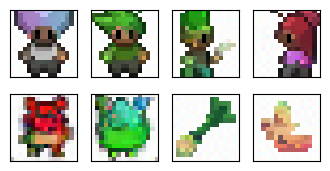

In [37]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)

noises = torch.randn(8, 3,
                     config.height, config.height).to(device)

samples, _ = sample_ddpm_context(nn_model, noises, ctx)
show_images(samples)

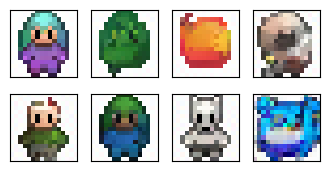

In [42]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],
    [0,0,0.6,0.4,0],
    [1,0,0,0,1],
    [1,1,0,0,0],
    [1,0,0,1,0],
    [1,0,0,0,0],      #human
    [0,1,0,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(nn_model, noises, ctx)
show_images(samples)